In [36]:
import numpy as np 
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
from astropy.modeling.powerlaws import SmoothlyBrokenPowerLaw1D as sbpl

In [81]:
def msbpl(x, amp, xb, a1, a2):
    s = 10
    return amp*((x/xb)**(-a1*s) + (x/xb)**(-a2*s))**(-1/s)
def dsbpl(x,amp,xb1,a1,a2,xb2,a3,s):
    if (a3 < a1) & (a1 < a2):
        result =  amp*(((x/xb1)**(a1*s) + (x/xb1)**(a2*s))**(-1) + (xb2/xb1)**(-a2*s)*(x/xb2)**(-a3*s))**(-1/s)
    elif (a3 < a2) & (a2 < a1):
        result = amp*((x/xb1)**(-a1*s) + (x/xb1)**(-a2*s) + ((xb1/xb2)**(a2*s))*((x/xb2)**(-a3*s)) )**(-1/s)
    else:
        raise Exception("Unhandled powerlaw index ordering")
    return result
def combinedPL(ivar, f0, nu0_1, nu0_2, a1, b1, b2, c1):
    t, nu = ivar
    s=10
    res = []
    t0 = 1
    c2 = 1/3
    c3 = -0.5
    for tval,nuval in zip(t,nu):
        fnu_m = f0*(tval/t0)**a1
        nua = nu0_1*(tval/t0)**b1
        num = nu0_2*(tval/t0)**b2
        if nuval < nua:
            fpk = fnu_m*(nua/num)**(1/3)
        else:
            fpk = fnu_m
        f = fpk*(nuval/nua)**(c1)
        result = dsbpl(nuval,fpk,nua,c1,c2,num,c3,s)
        res.append(result)
    return np.array(res)
def wrap_sbpl(t,amp, tb, a1, a2):
    d=0.2
    f = sbpl(amplitude=amp, x_break=tb, alpha_1=-a1, alpha_2=-a2, delta=d)
    return f(t)


99.99999999999997 2.2268891513198058e-63 464.1588833612779 1.6196946875602628e-59 0.5 2.1190896188801952e-71 -0.75 2.193399703734947e-70


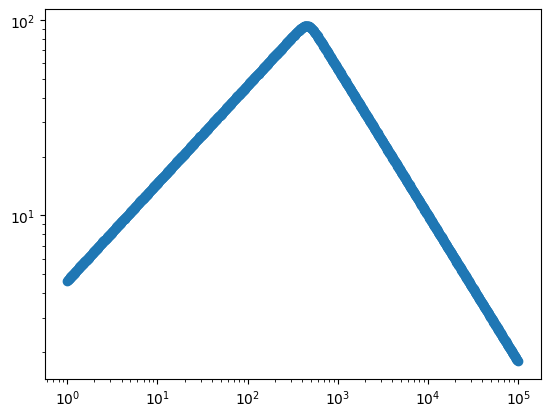

In [96]:
fig = plt.figure()
t = np.geomspace(1,100000,num=10000)
nu = np.full(t.shape,1)
ivar = (t,nu)
y = combinedPL(ivar, 1e3, 10, 100, 0, 0, -3/2, 2)
# def powerlaw(x,f0,a1):
#     x_break=1
#     return f0*(x/x_break)**a1
# popt,pcov = curve_fit(powerlaw, t[0:10], y[0:10])
# print(popt[0],pcov[0][0]**2, popt[1], pcov[1][1]**2)
# popt,pcov = curve_fit(powerlaw, t[0:10], y[0:10])
# print(popt[0],pcov[0][0]**2, popt[1], pcov[1][1]**2)
initial_guess = [10,4e4,0.5,-1]
bounds = [(1,1e6),(1,1e6),(0.01,2),(-4,-0.01)]
bounds0 = tuple([b[0] for b in bounds])
bounds1 = tuple([b[1] for b in bounds])
bounds = [bounds0,bounds1]

popt, pcov = curve_fit(msbpl,t,y,bounds=bounds,p0=initial_guess)
print(popt[0],pcov[0][0]**2, popt[1], pcov[1][1]**2, popt[2], pcov[2][2]**2, popt[3], pcov[3][3]**2)
plt.scatter(t,y,color='black',s=0.1, alpha=0.05)
plt.scatter(t[::10], msbpl(t[::10],*popt))
ax = plt.gca()
ax.set_xscale('log')
ax.set_yscale('log')
plt.show()
plt.close()

Note that the above plot fits theoretical expectations when nu < nu_a. It is confirmed to not fit expectations when nu > nu_a. Have Alexander confirm that his values are correct for these regimes. I have only tested the ISM medium thus far. 

1000.0 6.7712848275782635e-62 2.0 1.869396940650707e-76


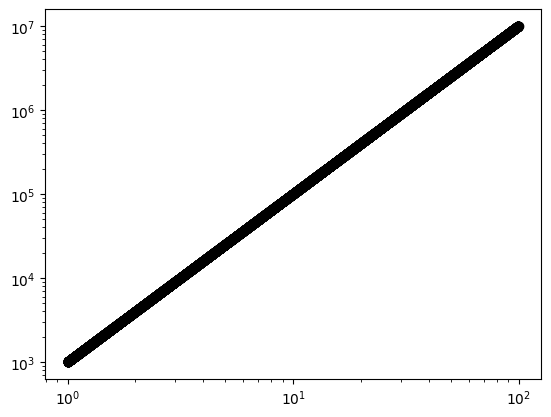

In [22]:
fig = plt.figure()
nu = np.geomspace(1,100,num=10000)
t = np.full(t.shape,1)
ivar = (t,nu)
y = combinedPL(ivar, 1e3, 1, -0.5, -0.5, 2)
def powerlaw(x,f0,a1):
    x_break=1
    return f0*(x/x_break)**a1
popt,pcov = curve_fit(powerlaw, nu, y)
print(popt[0],pcov[0][0]**2, popt[1], pcov[1][1]**2)
plt.scatter(nu,y,color='black')
ax = plt.gca()
ax.set_xscale('log')
ax.set_yscale('log')
plt.show()
plt.close()

3085.6567788772004 7.528056305769792e-29 42747.04733045598 1.226934076881275e-34 0.4949862077537176 1.4176010196210297e-11 -1.0 0.0


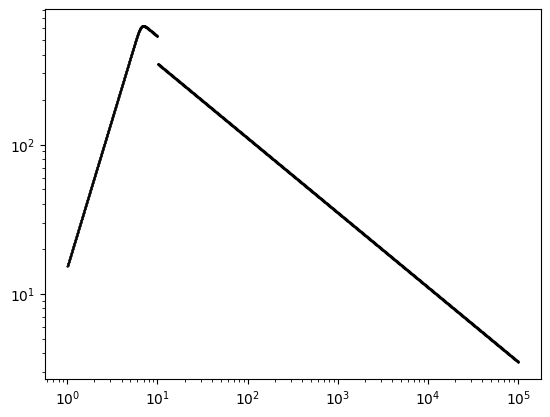

In [91]:
fig = plt.figure()
nu = np.geomspace(1,100000,num=10000)
t = np.full(nu.shape,50)
ivar = (t,nu)
y = combinedPL(ivar, 1e3, 10, 1000, 0, 0, -3/2, 2)
# def powerlaw(x,f0,a1):
#     x_break=1
#     return f0*(x/x_break)**a1
# popt,pcov = curve_fit(powerlaw, t[0:10], y[0:10])
# print(popt[0],pcov[0][0]**2, popt[1], pcov[1][1]**2)
# popt,pcov = curve_fit(powerlaw, t[0:10], y[0:10])
# print(popt[0],pcov[0][0]**2, popt[1], pcov[1][1]**2)
initial_guess = [10,4e4,0.5,-1]
bounds = [(1,1e6),(1,1e6),(0.01,2),(-4,-0.01)]
bounds0 = tuple([b[0] for b in bounds])
bounds1 = tuple([b[1] for b in bounds])
bounds = [bounds0,bounds1]

popt, pcov = curve_fit(msbpl,t,y,bounds=bounds,p0=initial_guess)
print(popt[0],pcov[0][0]**2, popt[1], pcov[1][1]**2, popt[2], pcov[2][2]**2, popt[3], pcov[3][3]**2)
plt.scatter(nu,y,color='black',s=0.1, alpha=0.5)
# plt.scatter(t[::10], msbpl(t[::10],*popt))
ax = plt.gca()
ax.set_xscale('log')
ax.set_yscale('log')
plt.show()
plt.close()